### Objectives:
1. Code ViT from Scratch in PyTorch
2. Train it on CIFAR 10 


Note: The codebase is based on the excellent ViT tutorial by Uygar Kurt


In [3]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
from torchvision import transforms
import timeit
from tqdm import tqdm
import pandas as pd
import torchvision

In [4]:
RANDOM_SEED = 42
BATCH_SIZE = 8
EPOCHS = 5
LEARNING_RATE = 1e-4
NUM_CLASSES = 10
PATCH_SIZE = 4
IMG_SIZE = 32
IN_CHANNELS = 3
NUM_HEADS = 8
DROPOUT = 0.001
HIDDEN_DIM = 768
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)
ACTIVATION = "gelu"
NUM_ENCODERS = 4
EMBED_DIM = (PATCH_SIZE ** 2) * IN_CHANNELS # 16
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2 # 49

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = "cuda" if torch.cuda.is_available() else "cpu"


In [5]:
class PatchEmbedding(nn.Module):
  def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
    super().__init__()
    self.patcher = nn.Sequential(
        nn.Conv2d(
            in_channels = in_channels,
            out_channels = embed_dim,
            kernel_size = patch_size,
            stride = patch_size
        ),
        nn.Flatten(2) # flattening starts from dim 2, batch_size, no_patches, height, width
    )

    self.cls_token = nn.Parameter(torch.randn(size = (1, 1, embed_dim)), requires_grad = True)
    self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches+1, embed_dim)), requires_grad = True) 
    self.dropout = nn.Dropout(p=dropout)

  def forward(self, x):
    x = x.to(device)
    cls_token = self.cls_token.expand(x.shape[0], -1, -1)
    x = self.patcher(x).permute(0, 2, 1) # Permute to make things appear more natural 
    x = torch.cat([cls_token, x], dim = 1)
    x = self.position_embeddings + x
    x = self.dropout(x)
    return x

model = PatchEmbedding(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS).to(device)






In [6]:
class ViT(nn.Module):
  def __init__(self, num_patches, img_size, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels):
    super().__init__()
    self.embedding_block = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels)

    encoder_layer = nn.TransformerEncoderLayer(d_model = embed_dim, nhead = num_heads, dropout = dropout, activation = activation, batch_first = True, norm_first= True)
    self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)

    self.mlp_head = nn.Sequential(
        nn.LayerNorm(normalized_shape = embed_dim),
        nn.Linear(in_features = embed_dim, out_features = num_classes)
    )


  def forward(self, x):
    x = self.embedding_block(x)
    x = self.encoder_blocks(x)
    x = self.mlp_head(x[:, 0, :])
    return x

model = ViT(NUM_PATCHES, IMG_SIZE, NUM_CLASSES, PATCH_SIZE, EMBED_DIM, NUM_ENCODERS, NUM_HEADS, HIDDEN_DIM, DROPOUT, ACTIVATION, IN_CHANNELS).to(device)



/home/azfarm/miniconda3/envs/MIDL/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [7]:
# Downloading CIFAR-10
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [8]:
# Splitting the train set into Val set

trainset, valset = train_test_split(trainset, test_size = 0.1, random_state = RANDOM_SEED, shuffle= True)
valloader = torch.utils.data.DataLoader(valset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


45000
(tensor([[[-0.8588, -0.8275, -0.7882,  ..., -0.7961, -0.8902, -0.9137],
         [-0.8588, -0.8353, -0.8039,  ..., -0.7882, -0.8353, -0.8667],
         [-0.8196, -0.8275, -0.8431,  ..., -0.7725, -0.8039, -0.8353],
         ...,
         [-0.6549, -0.6235, -0.5686,  ...,  0.0196, -0.1765, -0.4902],
         [-0.8039, -0.7725, -0.7020,  ..., -0.0196, -0.2863, -0.6157],
         [-0.8745, -0.8510, -0.8275,  ..., -0.2078, -0.5686, -0.7961]],

        [[-0.9059, -0.8745, -0.8353,  ..., -0.8510, -0.9137, -0.9216],
         [-0.9059, -0.8824, -0.8510,  ..., -0.8196, -0.8353, -0.8588],
         [-0.8667, -0.8745, -0.8902,  ..., -0.7804, -0.7961, -0.8039],
         ...,
         [-0.8118, -0.7961, -0.7569,  ...,  0.0275, -0.1843, -0.5294],
         [-0.8667, -0.8353, -0.7804,  ..., -0.0039, -0.3020, -0.6706],
         [-0.8980, -0.8745, -0.8588,  ..., -0.2157, -0.6000, -0.8510]],

        [[-0.8118, -0.7804, -0.7412,  ..., -0.7647, -0.8588, -0.8745],
         [-0.8118, -0.7882, -0.7569,  

<Figure size 640x480 with 0 Axes>

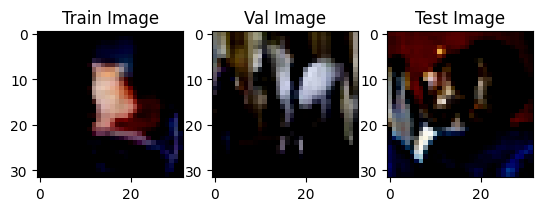

In [9]:
plt.figure()
f, axarr = plt.subplots(1, 3)
print(len(trainset))
print(trainset[0])
axarr[0].imshow(trainset[0][0].squeeze().permute(1, 2, 0), cmap='gray')
axarr[0].set_title("Train Image")
print("-"*30)

print(len(valset))
print(valset[0])
axarr[1].imshow(valset[0][0].squeeze().permute(1, 2, 0), cmap='gray')
axarr[1].set_title("Val Image")
print("-"*30)

print(len(testset))
print(testset[0])
axarr[2].imshow(testset[0][0].squeeze().permute(1, 2, 0), cmap='gray')
axarr[2].set_title("Test Image")
print("-"*30)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr= LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)

start = timeit.default_timer()
for epoch in tqdm(range(EPOCHS), position=0, leave =True):
  model.train()
  train_labels = []
  train_preds = []
  train_running_loss = 0
  for idx, img_label in enumerate(tqdm(trainloader, position =0, leave=True)):
    img = img_label[0].float().to(device)
    label = img_label[1].type(torch.uint8).to(device)
    y_pred = model(img)
    y_pred_label = torch.argmax(y_pred, dim = 1)

    train_labels.extend(label.cpu().detach())
    train_preds.extend(y_pred_label.cpu().detach())

    loss =criterion(y_pred, label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_running_loss += loss.item()
  train_loss = train_running_loss/ (idx + 1)

  model.eval()
  val_labels = []
  val_preds = []
  val_running_loss = 0
  with torch.no_grad():
    for idx, img_label in enumerate(tqdm(valloader, position = 0, leave= True)):
      img = img_label[0].float().to(device)
      label = img_label[1].type(torch.uint8).to(device)
      y_pred = model(img)
      y_pred_label = torch.argmax(y_pred, dim = 1)

      val_labels.extend(label.cpu().detach())
      val_preds.extend(y_pred_label.cpu().detach())

      loss = criterion(y_pred, label)

      val_running_loss += loss.item()
    val_loss = val_running_loss / (idx + 1)
  print("-"*30)
  print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
  print(f"Val Loss EPOCH {epoch+1}: {val_loss:.4f}")
  print(f"Train Accuracy EPOCH {epoch+1}: {sum(1 for x, y in zip(train_preds, train_labels) if x == y) / len(train_labels):.4f}")
  print(f"Val Accuracy EPOCH {epoch+1}: {sum(1 for x, y in zip(val_preds, val_labels) if x == y) / len(val_labels):.4f}")

stop = timeit.default_timer()
print(f"Training Time: {stop-start:2f}s")





100%|██████████| 625/625 [00:03<00:00, 166.16it/s]


------------------------------
Train Loss EPOCH 1: 1.8349
Val Loss EPOCH 1: 1.6296


 20%|██        | 1/5 [01:24<05:38, 84.71s/it]

Train Accuracy EPOCH 1: 0.3256
Val Accuracy EPOCH 1: 0.4046


100%|██████████| 625/625 [00:03<00:00, 160.80it/s]


------------------------------
Train Loss EPOCH 2: 1.5208
Val Loss EPOCH 2: 1.4572


 40%|████      | 2/5 [02:49<04:13, 84.53s/it]

Train Accuracy EPOCH 2: 0.4488
Val Accuracy EPOCH 2: 0.4758


100%|██████████| 625/625 [00:03<00:00, 163.89it/s]


------------------------------
Train Loss EPOCH 3: 1.4023
Val Loss EPOCH 3: 1.3315


 60%|██████    | 3/5 [04:13<02:48, 84.42s/it]

Train Accuracy EPOCH 3: 0.4932
Val Accuracy EPOCH 3: 0.5174


100%|██████████| 625/625 [00:03<00:00, 165.11it/s]


------------------------------
Train Loss EPOCH 4: 1.3207
Val Loss EPOCH 4: 1.2740


 80%|████████  | 4/5 [05:37<01:24, 84.36s/it]

Train Accuracy EPOCH 4: 0.5240
Val Accuracy EPOCH 4: 0.5430


100%|██████████| 625/625 [00:04<00:00, 154.98it/s]


------------------------------
Train Loss EPOCH 5: 1.2639
Val Loss EPOCH 5: 1.2358


100%|██████████| 5/5 [07:02<00:00, 84.42s/it]

Train Accuracy EPOCH 5: 0.5449
Val Accuracy EPOCH 5: 0.5552
Training Time: 422.112375s


### To do:
* Implement the model with just MultiheadAttention
